In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.process import preprocess
from utils.plot_feature_reduction import *

# Introduction

We have a lot of input features and many labels. The goal of this Notebook is to see if we can trim the number of input features based on an array of different processing methods. For this Notebook, I will look at the following relationships to determine whether an input feature is relevant:
- correlations
- feature importances
- feature ranking with recursive feature elimination
- Principle Component Analysis (PCA)

Another interesting thing to look at would be to see what output features (labels) we can reasonably expect a machine learning model to predict. For instance, it may be that we can only predict half of the avlanche bulletin's output fields.

# Read in data

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


# Data formatting, overall distributions

I go through some of these processing steps (with more printouts) in the Notebook on data distributions, so will not go through them here.

In [3]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [4]:
print(regions.shape)
print(labels.shape)

(13115, 245)
(13115, 69)


All of our input data set columns are either type int or float. However, there are several columns in the labels that are not.

In [5]:
def check_label_types(l):
    """
    Prints the columns in our labels that have type other than int or float.
    If nothing is printed, all columns are either int or float type.
    
    Arguments:
        l(DataFrame): the output columns we are trying to predict for
    """
    for column in l.columns:
        #if(isinstance(labels[column].dtypes, np.int)):
        is_not_int = l[column].dtype is not np.dtype(np.int64)
        is_not_float = l[column].dtype is not np.dtype(np.float64)

        if(np.logical_and(is_not_int, is_not_float)):
            print(l[column].dtypes, '     ', column)

In [6]:
check_label_types(labels)

object       CLASS_drift_slab_cause
object       CLASS_glide_cause
object       CLASS_new_loose_cause
object       CLASS_new_slab_cause
object       CLASS_pwl_slab_cause
object       CLASS_wet_loose_cause
object       CLASS_wet_slab_cause
object       MULTI_drift_slab_aspect
object       MULTI_glide_aspect
object       MULTI_new_loose_aspect
object       MULTI_new_slab_aspect
object       MULTI_pwl_slab_aspect
object       MULTI_wet_loose_aspect
object       MULTI_wet_slab_aspect


We can first work on the `_cause` columns. Let's see what one of these columns looks like in terms of unique values.

In [7]:
np.unique(labels['CLASS_drift_slab_cause'])

array(['0', 'crust', 'new-snow', 'snowdrift'], dtype=object)

We will need to one-hot encode these.

In [8]:
labels.shape

(13115, 69)

In [9]:
def encode_causes(l):
    """
    One-hot encode the avalanche cause columns.
    
    Arguments:
        l(DataFrame): labels for data set prior to one-hot encoding
        
    Returns:
        l(DataFrame): labels for data set after to one-hot encoding
    """
    cause_columns = ['CLASS_drift_slab_cause', 'CLASS_glide_cause', 'CLASS_new_loose_cause',
                     'CLASS_new_slab_cause', 'CLASS_pwl_slab_cause', 'CLASS_wet_loose_cause', 
                     'CLASS_wet_slab_cause']
    l = pd.get_dummies(l, columns=cause_columns, dtype=np.int64)
    l.columns = [col.replace('-', '_') for col in l.columns.values]
    
    return l

In [10]:
labels = encode_causes(labels)

In [11]:
labels.shape

(13115, 89)

So we added 20 columns (while removing the original `_cause` columns) to the data set when we one-hot encoded them.

Now we can move onto the `_aspect` columns. These are more problematic.

In [12]:
aspect_columns = ['MULTI_drift_slab_aspect', 'MULTI_glide_aspect', 'MULTI_new_loose_aspect', 
                  'MULTI_new_slab_aspect', 'MULTI_pwl_slab_aspect', 'MULTI_wet_loose_aspect', 
                  'MULTI_wet_slab_aspect']
labels.loc[:, aspect_columns]

,,MULTI_drift_slab_aspect,MULTI_glide_aspect,MULTI_new_loose_aspect,MULTI_new_slab_aspect,MULTI_pwl_slab_aspect,MULTI_wet_loose_aspect,MULTI_wet_slab_aspect
region,date,,,,,,,
3031,2017-11-23,11100011,00000000,00000000,00000000,00000000,00000000,00000000
3034,2017-11-23,11100011,00000000,00000000,00000000,00000000,00000000,00000000
3003,2017-12-02,11111111,00000000,00000000,00000000,00000000,00000000,00000000
3007,2017-12-02,00000000,00000000,00000000,00000000,11111111,00000000,00000000
3009,2017-12-02,00000000,00000000,00000000,00000000,11111111,00000000,00000000
...,...,...,...,...,...,...,...,...
3031,2021-01-12,00000000,00000000,00000000,00000000,11111111,00000000,00000000
3032,2021-01-12,00000000,00000000,00000000,00000000,11111111,00000000,00000000
3034,2021-01-12,00000000,00000000,00000000,00000000,11111111,00000000,00000000


In [13]:
for i, row in enumerate(range(11)):
    print(i, labels.loc[:, aspect_columns].replace('00000000', np.nan).iloc[i, :].values)

0 ['11100011' nan nan nan nan nan nan]
1 ['11100011' nan nan nan nan nan nan]
2 ['11111111' nan nan nan nan nan nan]
3 [nan nan nan nan '11111111' nan nan]
4 [nan nan nan nan '11111111' nan nan]
5 [nan nan nan nan '11111111' nan nan]
6 [nan nan nan nan '11111111' nan nan]
7 [nan nan nan nan '11001111' nan nan]
8 [nan nan nan nan '10001111' nan nan]
9 ['11111111' nan nan nan nan nan nan]
10 ['11100011' nan nan nan '11111111' nan nan]


Okay, so we see that at index 10, we have two values for a given region on a given day for the aspect on the avalanche bulletin. This is because more than one problem can be given at a time (up to 3, but most often 1 or 2). So we can't split this into 7 distinct columns, 1 for each aspect/avalanche problem combination, but instead we have to one-hot encode each of these columns into *8* different columns, for a total of 56 columns. This is disappointing when we are trying to cut down on the size of the data, but there is no other way around it unless we wanted to drop these columns altogether (which we don't).

In [14]:
def encode_aspects(l):
    """
    Encode the avalanche aspect columns in the labels of our data set.
    
    Arguments:
        l(DataFrame): labels for data set prior to encoding the aspect columns
        
    Returns:
        l(DataFrame): labels for data set after to encoding the aspect columns
    """
    aspect_columns = ['MULTI_drift_slab_aspect', 'MULTI_glide_aspect', 'MULTI_new_loose_aspect', 
                      'MULTI_new_slab_aspect', 'MULTI_pwl_slab_aspect', 'MULTI_wet_loose_aspect', 
                      'MULTI_wet_slab_aspect']
    
    for column in aspect_columns:
        for i in range(0, 8):
            new_aspect_column = column + '_' + str(i)
            aspect = [int(element[i]) for element in l.loc[:, column]]
            l[new_aspect_column] = aspect
            l[new_aspect_column] = l[new_aspect_column].astype(int)
        
    l.drop(aspect_columns, axis=1, inplace=True)
        
    return l

In [15]:
labels = encode_aspects(labels)
labels.shape

(13115, 138)

We had 89 columns after encoding the cause, plus 56 aspect columns and subtracting the 7 original aspect columns, that gives us 138. Let's make sure that we did the encoding correctly.

In [16]:
test_col = 'MULTI_drift_slab_aspect'
check_cols = [test_col+'_'+str(i) for i in list(range(0, 8))]
compare = labels.loc[:, check_cols][:11]

for row in range(len(compare.index)):
    element_list = [''+str(element) for element in compare.iloc[row].values]
    to_print = ''.join(element_list)
    if(to_print == '00000000'):
        print(row, np.nan)
    else:
        print(row, to_print)

0 11100011
1 11100011
2 11111111
3 nan
4 nan
5 nan
6 nan
7 nan
8 nan
9 11111111
10 11100011


This is looking good. We can compare this output to the first column in the printout above when we were intially checking for duplicate entries.

Now we should not have any columns that are not of type float or int in our labels, so the following loop should not produce any output.

In [17]:
check_label_types(labels)

# Correlation analysis

In [18]:
features_and_labels = features = pd.concat([regions, labels], axis=1)
features_and_labels.shape

(13115, 383)

In [19]:
# drop columns that include text, create correlations matrix
only_numeric = features_and_labels.select_dtypes(include='number')
correlations = only_numeric.corr()

# shorten the x axis to only the labels
keep_cols = [col for col in labels if col in correlations.columns]
drop_rows = list(set(correlations.columns) - set(keep_cols))
correlations = correlations.loc[drop_rows, keep_cols]

# there are some rows with only nan values, we can drop those here
empty_rows = [item for item in correlations.index if correlations.loc[item].isna().all() == True]
correlations.drop(empty_rows, inplace = True)

In [20]:
print(correlations.shape)

(183, 138)


**Another thing to try would be to drop all rows where the absolute value of the correlation is below 0.25 or 0.25, for all values. These input features probably don't need to be considered.**

In [21]:
np.sum([(abs(correlations.loc[idx, :].values) < 0.50).all() for idx in correlations.index])

73

In [22]:
weak_correlations = [(abs(correlations.loc[idx, :].values) < 0.50).all() for idx in correlations.index]
correlations.loc[weak_correlations, :].shape

(73, 138)

In [23]:
sorted(correlations.loc[weak_correlations, :].index)

['emergency_warning_1',
 'precip_0',
 'precip_most_exposed_0',
 'problem_drift_slab_lev_fill_4_1',
 'problem_glide_lev_fill_1_1',
 'problem_glide_lev_fill_3_1',
 'problem_new_loose_1',
 'problem_new_loose_aspect_E_1',
 'problem_new_loose_aspect_NE_1',
 'problem_new_loose_aspect_NW_1',
 'problem_new_loose_aspect_N_1',
 'problem_new_loose_aspect_SE_1',
 'problem_new_loose_aspect_SW_1',
 'problem_new_loose_aspect_S_1',
 'problem_new_loose_aspect_W_1',
 'problem_new_loose_cause_loose_1',
 'problem_new_loose_dist_1',
 'problem_new_loose_dsize_1',
 'problem_new_loose_lev_fill_1_1',
 'problem_new_loose_lev_fill_2_1',
 'problem_new_loose_lev_fill_4_1',
 'problem_new_loose_lev_max_1',
 'problem_new_loose_lev_min_1',
 'problem_new_loose_prob_1',
 'problem_new_loose_trig_1',
 'problem_new_slab_aspect_NW_1',
 'problem_new_slab_aspect_N_1',
 'problem_new_slab_aspect_SE_1',
 'problem_new_slab_aspect_SW_1',
 'problem_new_slab_aspect_S_1',
 'problem_new_slab_aspect_W_1',
 'problem_new_slab_cause_crust

In [24]:
drop_weak = correlations.loc[weak_correlations, :].index.values
correlations.drop(drop_weak, inplace=True)
correlations.shape

(110, 138)

In [25]:
keep_columns_correlations = list(correlations.index)
#keep_columns_correlations

Are there also labels that are going to be hard to predict in the avalanche bulletin? We can look at the columns in our correlation matrix in the same way that we did for the input features.

In [26]:
np.sum([(abs(correlations.loc[:, col].values) < 0.50).all() for col in correlations.columns])

31

In [29]:
weak_labels = [(abs(correlations.loc[:, col].values) < 0.50).all() for col in correlations.columns]
drop_weak_labels = correlations.loc[:, weak_labels].columns
sorted(correlations.loc[:, weak_labels].columns.values)

['CLASS_emergency_warning',
 'CLASS_new_loose_cause_0',
 'CLASS_new_loose_cause_loose',
 'CLASS_new_loose_dist',
 'CLASS_new_loose_dsize',
 'CLASS_new_loose_lev_fill',
 'CLASS_new_loose_prob',
 'CLASS_new_loose_trig',
 'CLASS_new_slab_cause_crust',
 'CLASS_problem_3',
 'CLASS_wet_slab_cause_crust',
 'CLASS_wet_slab_cause_water_layers',
 'CLASS_wet_slab_dist',
 'CLASS_wet_slab_lev_fill',
 'MULTI_new_loose_aspect_0',
 'MULTI_new_loose_aspect_1',
 'MULTI_new_loose_aspect_2',
 'MULTI_new_loose_aspect_3',
 'MULTI_new_loose_aspect_4',
 'MULTI_new_loose_aspect_5',
 'MULTI_new_loose_aspect_6',
 'MULTI_new_loose_aspect_7',
 'MULTI_new_slab_aspect_0',
 'MULTI_new_slab_aspect_3',
 'MULTI_new_slab_aspect_4',
 'MULTI_new_slab_aspect_5',
 'MULTI_new_slab_aspect_6',
 'MULTI_new_slab_aspect_7',
 'MULTI_wet_slab_aspect_4',
 'REAL_new_loose_lev_max',
 'REAL_new_loose_lev_min']

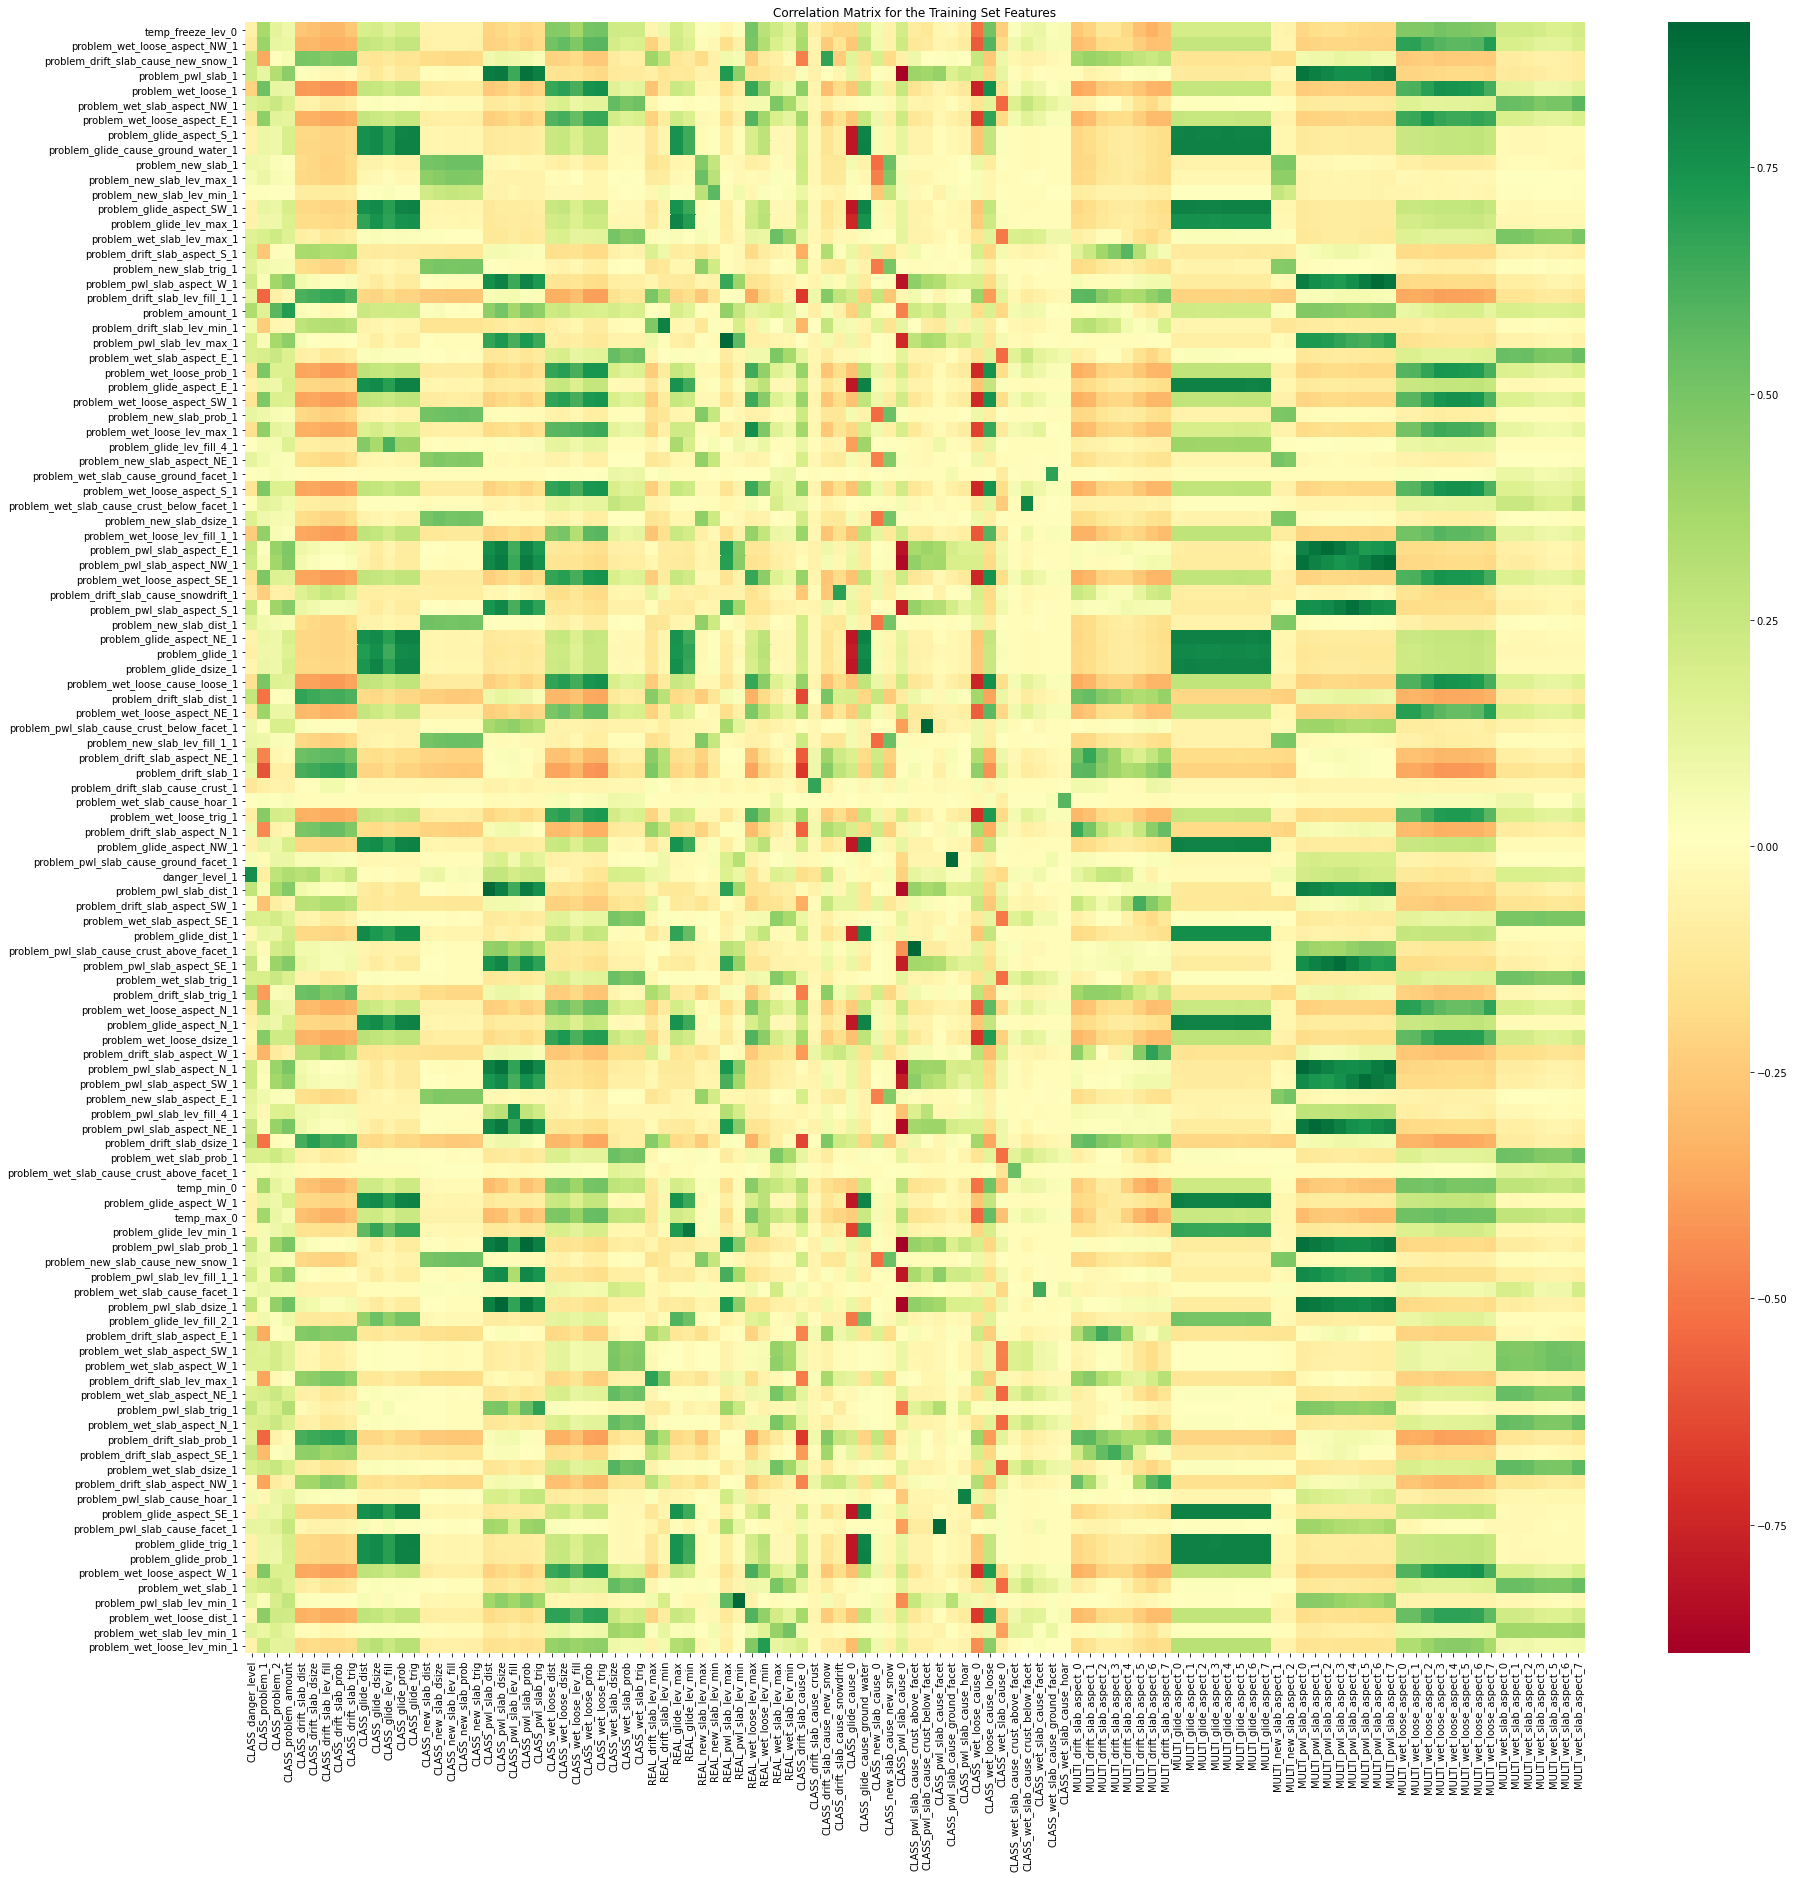

In [30]:
fig, ax = plt.subplots(figsize=(30, 30))

sns.heatmap(correlations.drop(drop_weak_labels, axis=1), 
            xticklabels=correlations.drop(drop_weak_labels, axis=1).columns, 
            yticklabels=correlations.index, cmap='RdYlGn', ax=ax)

ax.set_title('Correlation Matrix for the Training Set Features')

plt.show()

**So according to our correlation analysis, there are about 110 features out of the original 291 that are useful in predicting one or more of our labels. We can save those below and compare them with what features our other analysis find useful.**

**Additionally, there are labels that aren't very highly correlated with any other input feature. `CLASS_problem_3` actually makes sense because there is almost never a 3rd problem reported on the avalanche bulletin. Interestingly, the `new_loose` avalanche problem and it's associated columns (`prob`, `lev_fill`, `lev_min/max`, `dist`, etc.) seem uncorrelated with the input features, meaning that this may be something that is hard for us to predict. Same for `wet_slab` and `new_slab`.**

**It may also come as no surprise that the aspect columns are almost 100% correlated with the aspect values from the day before.**

# Feature importances

Next, we can look at which features a Random Forest model thinks are important. To do this, we can use the whole dataset as a predictor for the labels.

In [31]:
X, y = regions.select_dtypes(include='number'), labels.select_dtypes(include='number')

num_iter = 10
random = 0   #makes sure the models and grid search object give the same results every time

#instantiate models here
forest = RandomForestRegressor(random_state=random)
#forest = RandomForestClassifier(random_state=random)

#define parameters dictionaries here
ensemble_params = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
             'max_depth': [1, 2, 4, 6, 8, 10, 20, 30, None],  #higher values often lead to overfitting
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
            'bootstrap': [True, False]
            }

#create our random search cv objects
forest_search = RandomizedSearchCV(estimator=forest,
                        param_distributions=ensemble_params,
                        n_iter=num_iter,         #number of parameter settings sampled
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,         #use all processors available
                        cv=5,
                        verbose=2,         #print results during tuning
                        random_state=random
)

#now fit the search objects and return them
forest_model = forest_search.fit(X, y)

print('Best RandomForest model:')
print(forest_model.best_params_, '\n')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RandomForest model:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True} 



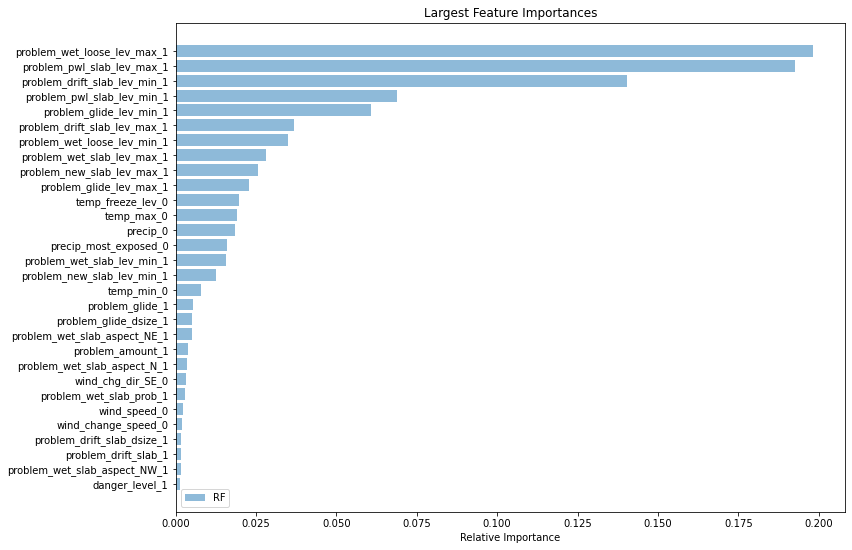

In [32]:
# need to make sure this is using the "best" model by default
ranked_importances, ranked_columns = plot_importances(regions, labels, forest_model) 

In [33]:
ranked_importances[:35]

array([0.19837466, 0.1926996 , 0.1404463 , 0.06895706, 0.06068994,
       0.03673237, 0.03486725, 0.02815065, 0.02574468, 0.02286322,
       0.01971362, 0.01911788, 0.0185287 , 0.01584308, 0.01550863,
       0.01240569, 0.00801408, 0.00527195, 0.00522336, 0.00497485,
       0.00369493, 0.00343882, 0.00318021, 0.00273761, 0.00235489,
       0.00207795, 0.00163383, 0.0015521 , 0.00149566, 0.00142779,
       0.00123169, 0.00122664, 0.00121479, 0.00119328, 0.00115079])

**After about index 35, the columns that the Random Forest model is splitting on have *very* little importance. Let's just keep the top 35 then for the sake of our comparison.**

**The Random Forest model thinks that min/max columns for each avalanche problem as well as temperature are very important, and to a lesser extent precipitation, freezing level, danger level, and wind speed.**

In [34]:
keep_columns_rf = ranked_columns[:35]
keep_columns_rf

['problem_wet_loose_lev_max_1',
 'problem_pwl_slab_lev_max_1',
 'problem_drift_slab_lev_min_1',
 'problem_pwl_slab_lev_min_1',
 'problem_glide_lev_min_1',
 'problem_drift_slab_lev_max_1',
 'problem_wet_loose_lev_min_1',
 'problem_wet_slab_lev_max_1',
 'problem_new_slab_lev_max_1',
 'problem_glide_lev_max_1',
 'temp_freeze_lev_0',
 'temp_max_0',
 'precip_0',
 'precip_most_exposed_0',
 'problem_wet_slab_lev_min_1',
 'problem_new_slab_lev_min_1',
 'temp_min_0',
 'problem_glide_1',
 'problem_glide_dsize_1',
 'problem_wet_slab_aspect_NE_1',
 'problem_amount_1',
 'problem_wet_slab_aspect_N_1',
 'wind_chg_dir_SE_0',
 'problem_wet_slab_prob_1',
 'wind_speed_0',
 'wind_change_speed_0',
 'problem_drift_slab_dsize_1',
 'problem_drift_slab_1',
 'problem_wet_slab_aspect_NW_1',
 'danger_level_1',
 'problem_wet_slab_dist_1',
 'problem_pwl_slab_1',
 'problem_drift_slab_dist_1',
 'temp_lev_0',
 'problem_drift_slab_trig_1']

# Principal Component Analysis

My goal for this section is to perform PCA on our input data as a means of dimensionality reduction. I want to see if there are any variables that explain some amount of shared variance (meaning that they contribute nothing extra to our analysis). If this is the case, we can drop those columns and save compute resources.

We can do this because Principle Components are orthogonal: this means that they should be completely uncorrelated with each other.

Thank you to these two excellent resources on how to compute the loadings matrix after doing PCA:
- https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html
- https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

In [35]:
# appply feature scaling
scaler = StandardScaler()

# fit and transform the data in one step
# now we move from a dataframe to a numpy array
scaled = pd.DataFrame(scaler.fit_transform(regions), columns=regions.columns, index=regions.index)
scaled.head()

,,danger_level_1,emergency_warning_1,problem_amount_1,problem_new_loose_1,problem_wet_loose_1,problem_new_slab_1,problem_drift_slab_1,problem_pwl_slab_1,problem_wet_slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-23,2.597059,0.332556,-0.953027,-0.098478,-0.589482,-0.431643,0.923998,-0.709996,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,-0.424190,-0.617928,2.351196,-0.674028,-0.525028
3034,2017-11-23,2.597059,0.332556,-0.953027,-0.098478,-0.589482,-0.431643,0.923998,-0.709996,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,-0.424190,-0.617928,2.351196,-0.674028,-0.525028
3003,2017-12-02,-1.530477,0.332556,-0.953027,-0.098478,-0.589482,-0.431643,0.923998,-0.709996,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,-0.424190,-0.617928,-0.425315,-0.674028,-0.525028
3007,2017-12-02,-0.154632,0.332556,0.707080,-0.098478,-0.589482,-0.431643,0.923998,1.009438,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,2.357435,-0.617928,2.351196,-0.674028,-0.525028
3009,2017-12-02,-0.154632,0.332556,0.707080,-0.098478,-0.589482,-0.431643,0.923998,1.009438,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,2.357435,-0.617928,2.351196,-0.674028,-0.525028


In [38]:
# fit and transform the data here, create principal components
pca = PCA()
pcs = pca.fit_transform(scaled)

# print the explained variance ratio of the first ten principal components
var_ratio = pca.explained_variance_ratio_
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

The Principal Components do not explain as much variance as we would like early on. It would be ideal if the first PC explained greater than 50% of the variance, but we don't reach that level until we keep around 10 components. Still, we can reduce the data set by over a third while still maintaining 95% of the explained variance.

In [39]:
# find the index where we cross 90% variance explained
# the first [0] moves from array to list object, the second isolates the first index
idx_90 = np.where(cumulative_var > 0.90)[0][0]

# for 95% variance explained
idx_95 = np.where(cumulative_var > 0.95)[0][0]

In [40]:
print('If we wanted to retain 90% of the variance explained, we would need to keep {} PCs.'.format(idx_90+1))

print('If we wanted to retain 95% of the variance explained, we would need to keep {} PCs.'.format(idx_95+1))

If we wanted to retain 90% of the variance explained, we would need to keep 59 PCs.
If we wanted to retain 95% of the variance explained, we would need to keep 73 PCs.


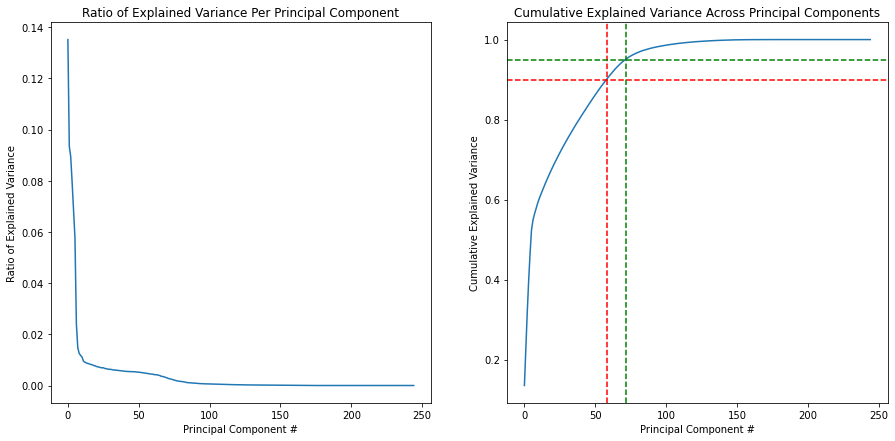

In [41]:
plot_explained_variance(var_ratio, cumulative_var, idx_90, idx_95)

In [42]:
# re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=idx_95+1)

#fit and transform the data here, create principal components
pcs = pca.fit_transform(scaled)

**"PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed."**

In [43]:
loadings = pd.DataFrame(pca.components_.T, index=regions.columns)
loadings

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
danger_level_1,-0.022479,-0.008791,0.054399,-0.003478,0.111719,0.039616,0.229460,-0.015946,-0.118505,-0.004704,...,0.006145,0.020351,0.085531,-0.030391,-0.052178,0.087572,-0.039023,0.180398,0.109626,-0.035357
emergency_warning_1,-0.025892,0.022090,-0.066179,0.000552,-0.078066,-0.028493,-0.129066,0.004562,0.097021,0.032968,...,0.001082,0.050147,-0.070446,0.000704,-0.023796,-0.016108,0.040205,0.082813,-0.067203,0.165346
problem_amount_1,0.038550,-0.006449,0.013606,-0.050234,0.205463,-0.030066,0.200715,0.166225,0.003376,0.003402,...,0.015312,0.003961,-0.047104,0.007374,-0.021226,-0.051313,0.015145,-0.033952,0.010518,-0.007261
problem_new_loose_1,0.003387,0.130612,-0.018221,0.189840,0.081719,-0.072339,-0.006768,-0.002964,0.000274,0.000173,...,-0.001859,-0.016643,-0.021874,-0.001775,0.000087,0.004869,-0.007652,-0.001862,0.004404,0.008061
problem_wet_loose_1,0.153319,-0.039515,-0.016423,-0.028350,-0.030419,-0.162845,0.027082,0.020093,-0.010910,0.019469,...,-0.019297,-0.009603,-0.034983,0.009189,0.021478,-0.029151,-0.004601,-0.036664,0.023970,-0.016998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_chg_start_18_0,-0.013760,0.000573,0.014532,0.000159,0.009519,0.013226,0.070256,-0.078500,-0.037355,-0.261978,...,-0.012294,-0.003884,0.010971,-0.045912,0.025233,-0.037377,-0.025994,0.001654,0.016230,-0.002118
temp_fl_start_0_0,0.003378,-0.006480,0.004056,-0.001084,0.002151,0.009532,-0.068063,0.051978,-0.106663,-0.151622,...,0.091837,0.066363,-0.043882,-0.044435,0.059833,-0.044690,0.027448,-0.006252,-0.006739,0.013930
temp_fl_start_6_0,-0.009839,-0.002210,0.017753,0.015414,-0.002609,0.025179,0.018303,-0.057911,0.005360,-0.048253,...,-0.047956,-0.045535,-0.035583,-0.056410,0.062223,-0.052463,0.010286,-0.020236,-0.004869,-0.022816
temp_fl_start_12_0,-0.002202,0.009229,-0.006123,-0.011104,0.014011,-0.014831,0.071262,-0.005240,0.050430,0.099418,...,-0.027968,0.008375,0.010741,0.038362,-0.022195,0.062469,-0.019968,0.023171,0.040126,0.013410


**"Another useful way to interpret PCA is by computing the correlations between the original variable and the principal components."**

In [44]:
loadings_sqrt = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings_sqrt,
                              columns=['PC'+str(i) for i in range(1, idx_95+2)],
                              index=regions.columns)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
danger_level_1,-0.111799,-0.036378,0.220078,-0.013267,0.395341,0.128716,0.482471,-0.026141,-0.179487,-0.006893,...,0.005362,0.017485,0.072030,-0.024493,-0.041936,0.068590,-0.029877,0.132918,0.077625,-0.024518
emergency_warning_1,-0.128774,0.091407,-0.267735,0.002106,-0.276252,-0.092578,-0.271379,0.007479,0.146948,0.048307,...,0.000944,0.043085,-0.059326,0.000567,-0.019125,-0.012617,0.030782,0.061018,-0.047586,0.114659
problem_amount_1,0.191729,-0.026684,0.055044,-0.191606,0.727072,-0.097687,0.422030,0.272508,0.005114,0.004984,...,0.013361,0.003403,-0.039669,0.005943,-0.017059,-0.040191,0.011595,-0.025016,0.007448,-0.005035
problem_new_loose_1,0.016846,0.540468,-0.073716,0.724092,0.289180,-0.235036,-0.014231,-0.004859,0.000414,0.000253,...,-0.001622,-0.014299,-0.018421,-0.001430,0.000070,0.003814,-0.005858,-0.001372,0.003119,0.005590
problem_wet_loose_1,0.762540,-0.163511,-0.066441,-0.108135,-0.107644,-0.529098,0.056943,0.032940,-0.016524,0.028528,...,-0.016839,-0.008250,-0.029461,0.007405,0.017262,-0.022832,-0.003522,-0.027014,0.016973,-0.011787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_chg_start_18_0,-0.068434,0.002373,0.058792,0.000607,0.033684,0.042973,0.147722,-0.128692,-0.056578,-0.383870,...,-0.010727,-0.003337,0.009239,-0.037002,0.020280,-0.029275,-0.019902,0.001219,0.011493,-0.001469
temp_fl_start_0_0,0.016801,-0.026815,0.016408,-0.004133,0.007613,0.030971,-0.143111,0.085212,-0.161551,-0.222168,...,0.080135,0.057017,-0.036955,-0.035811,0.048088,-0.035003,0.021015,-0.004607,-0.004772,0.009660
temp_fl_start_6_0,-0.048934,-0.009143,0.071821,0.058792,-0.009232,0.081809,0.038483,-0.094938,0.008119,-0.070704,...,-0.041845,-0.039122,-0.029966,-0.045463,0.050009,-0.041091,0.007875,-0.014910,-0.003448,-0.015822
temp_fl_start_12_0,-0.010950,0.038191,-0.024772,-0.042354,0.049579,-0.048189,0.149839,-0.008590,0.076382,0.145675,...,-0.024404,0.007196,0.009045,0.030917,-0.017838,0.048928,-0.015288,0.017073,0.028413,0.009299


In [45]:
pc_corr_list = []

for i in range(1, 11):
    col = 'PC'+str(i)
    #top = pd.DataFrame(loading_matrix.loc[:, col]).sort_values(by=col, ascending=False)[0:10]
    #bottom = pd.DataFrame(loading_matrix.loc[:, col]).sort_values(by=col, ascending=False)[-10:]
    #pc_corr = pd.concat([top, bottom], axis=0)
    pc_corr = pd.DataFrame(loading_matrix.loc[:, col]).sort_values(by=col, ascending=False)[0:10]
    
    pc_corr_list.append(pc_corr)
    
top_ten_pc_corrs = pd.concat(pc_corr_list, axis=1)
top_ten_pc_corrs.shape

(92, 10)

In [46]:
def color_realvals_green(val):
    """
    Takes a value and returns a string with the css 
    property `'color: green'` for real values, black otherwise.
    """
    color = 'lime' if np.isnan(val) == False else ''
    return 'background-color: %s' % color

In [47]:
s = top_ten_pc_corrs.style.applymap(color_realvals_green)
s

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
problem_wet_loose_cause_loose_1,0.774606,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_aspect_SE_1,0.773351,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_aspect_S_1,0.768725,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_aspect_SW_1,0.768211,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_prob_1,0.767491,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_aspect_W_1,0.765604,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_1,0.762540,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_dsize_1,0.744182,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_dist_1,0.737538,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet_loose_aspect_E_1,0.735417,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [48]:
keep_columns_pca = list(top_ten_pc_corrs.index)
#keep_columns_pca

**According to our Principle Component Analysis, there are somewhere between 59-73 important input features (depending on how much variance from the input data we want to explain).**

# t-SNE

t-SNE, or t-distributed stochastic neighbor embedding, is another feature reduction technique that we can use to try and distill which input features are important. We can do this by mapping input data in high dimensions to only 2 or 3 dimensions to see "clusters" of points. This would tell us how similar two clusters are to each other, since the t-SNE algorithm relies on the Euclidean distance between points, and since t-SNE tries to preserve this distance even when mapping points to lower dimensions.

If you are interested in learning more about t-SNE and how it is similar or different from PCA, the Wikipedia page and this DataCamp tutorial have more information:
- https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
- https://www.datacamp.com/community/tutorials/introduction-t-sne

In [52]:
tsne2d = TSNE(n_components=2, random_state=42).fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=42).fit_transform(X)

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


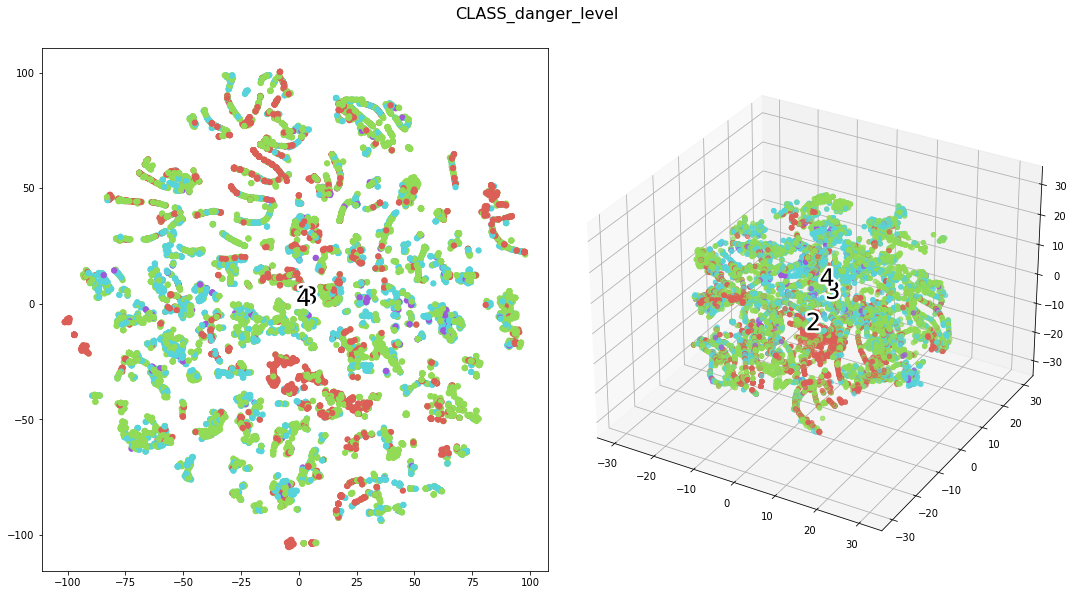

In [98]:
col = 'CLASS_danger_level'
plot_data_clusters(tsne2d, tsne3d, y[col].values, col)

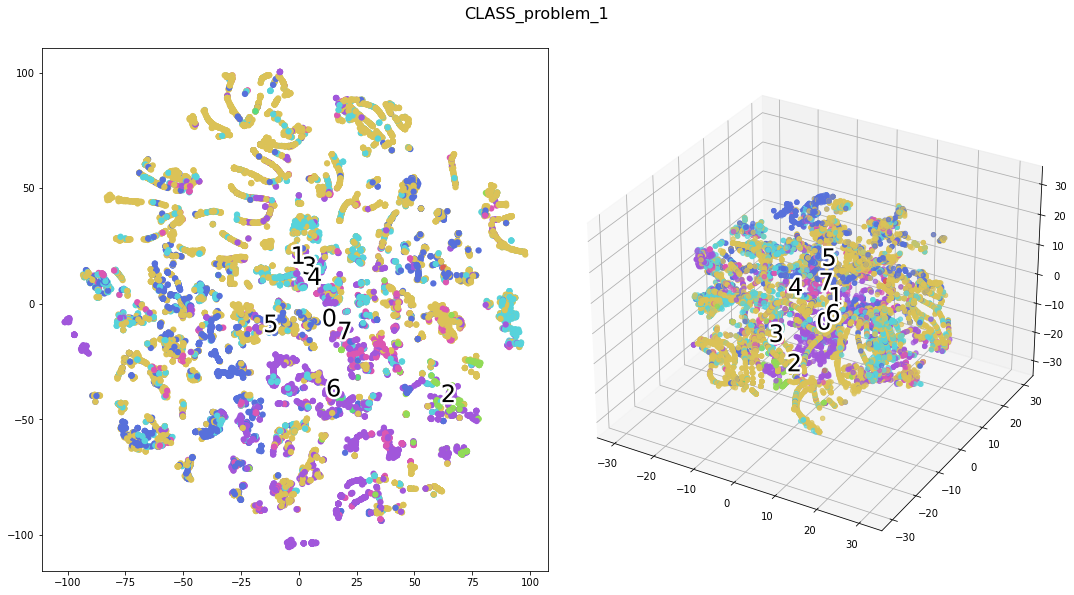

In [99]:
col = 'CLASS_problem_1'
plot_data_clusters(tsne2d, tsne3d, y[col].values, col)

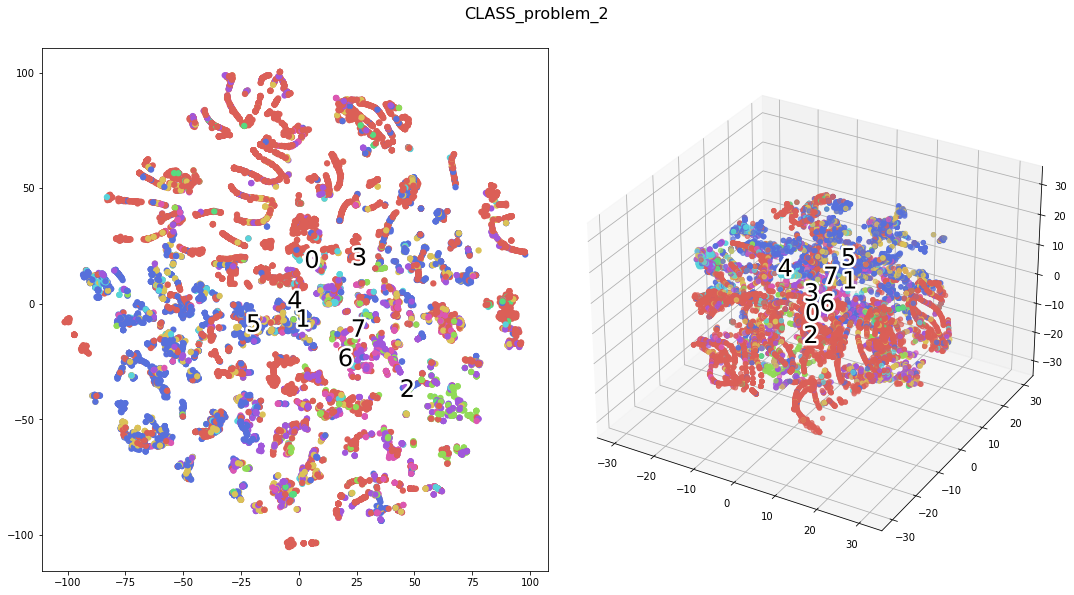

In [100]:
col = 'CLASS_problem_2'
plot_data_clusters(tsne2d, tsne3d, y[col].values, col)

t-SNE did not give us much hope of separating out the data by danger level or by avalanche problem 1 or 2 in an absolute sense. This means that many of the avalanche problems are likely inter-related and are often difficult to differentiate between completely. However, PCA showed that the avalanche problems are somewhat distinguishable if you take into account many different features relating to the same avalanche problem.

# Recursive Feature Elimination

We can also use several different models to evaluate or rank input feature importance by slowly eliminating features from a model and seeing how that affects performance. This is called recursive feature elimination. To learn more about how this is implemented in Scikit-Learn, please see [this](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) link.

- https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [65]:
# let's time the whole process
start = time.time()

# create the RFE object
#svc = SVC(kernel="linear", C=1)
lr = LinearRegression()
#lr = sklearn.linear_model.LogisticRegression()
#sgd = SGDClassifier()
#rtc = RandomForestRegression()
model = lr

n_features = 50
rfe = RFE(estimator=model, n_features_to_select=n_features, step=5, verbose=0)

# X and y were defined in the previous section on feature importances
print('Starting RFE to select top {} features.'.format(n_features))
#rfe.fit(X, y.iloc[:, 0])
rfe.fit(X, y)

end = time.time()
total_time = end - start
print('RFE took {}s with a {} model'.format(total_time, model))

Starting RFE to select top 50 features.
RFE took 3.759387254714966s with a LinearRegression() model


**^^ so we would have to do this for every output target column.**

I am not sure of a good way to do this automatically, and it would also take a **very** long time if we were using something like a SVM.

##### Look at https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV for automating number of features selected

In [66]:
# the estimated best features have a ranking of 1
rfe.ranking_

array([23, 23, 18,  2, 10, 13, 12, 13, 12,  4,  8,  1,  9, 14, 26, 27, 29,
       30, 28, 29, 30, 30, 29, 29, 29, 28,  1,  1,  1, 30,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 12, 14, 18, 19, 26, 27, 32, 31, 30, 31, 31, 32,
       31, 33, 32, 31,  1,  1,  1,  1,  1,  3,  2, 11, 10,  5,  1, 11, 11,
       21, 22, 21, 18, 27, 26,  3, 32, 35,  4, 33, 36, 32, 35, 34, 35, 33,
        8,  1, 33,  2, 19, 17, 20, 19, 13, 18, 16, 16, 24, 21, 23, 24, 26,
       26,  2, 37, 33,  3,  3, 35, 34, 37, 35, 34, 34, 10, 34, 36,  8, 21,
       23, 22, 22, 19, 12, 20, 22, 20, 19, 20, 21, 25, 25, 36,  1,  1, 37,
       37,  1,  1,  1, 38, 37, 38,  1,  1,  1,  1, 17, 17, 17, 17, 22, 16,
        5,  4, 13, 18, 16, 20, 27, 28, 36,  1,  1,  1, 36,  1,  1,  1, 38,
        1, 38,  1,  1, 38,  1,  8,  3,  4, 10,  7,  6,  7,  9,  4, 13,  7,
        8, 27, 25, 40, 40, 39, 39, 39, 39, 40, 40,  1, 40, 39,  1,  1,  1,
        1,  1,  2,  1,  1,  7,  1,  1,  1, 24, 24, 25, 25, 24, 23, 28, 28,
        5,  5,  5,  6,  7

In [67]:
f_elim_df = pd.DataFrame(rfe.ranking_, index=X.columns, columns=['Rank']).sort_values(by='Rank',ascending=True)
f_elim_df.head(n_features)

,Rank
problem_pwl_slab_cause_facet_1,1
problem_new_loose_aspect_N_1,1
problem_new_loose_aspect_NE_1,1
problem_new_loose_aspect_E_1,1
problem_new_loose_aspect_SE_1,1
problem_new_loose_aspect_SW_1,1
problem_new_loose_aspect_W_1,1
problem_new_loose_aspect_NW_1,1
problem_wet_slab_lev_fill_4_1,1
problem_glide_cause_ground_water_1,1


In [68]:
keep_columns_rfe = f_elim_df.index.values[:n_features]
keep_columns_rfe

array(['problem_pwl_slab_cause_facet_1', 'problem_new_loose_aspect_N_1',
       'problem_new_loose_aspect_NE_1', 'problem_new_loose_aspect_E_1',
       'problem_new_loose_aspect_SE_1', 'problem_new_loose_aspect_SW_1',
       'problem_new_loose_aspect_W_1', 'problem_new_loose_aspect_NW_1',
       'problem_wet_slab_lev_fill_4_1',
       'problem_glide_cause_ground_water_1', 'problem_glide_lev_fill_1_1',
       'problem_glide_lev_fill_2_1', 'problem_glide_lev_fill_3_1',
       'problem_glide_aspect_NW_1', 'problem_glide_aspect_W_1',
       'problem_glide_aspect_SW_1', 'problem_glide_lev_fill_4_1',
       'problem_glide_aspect_SE_1', 'problem_wet_loose_cause_loose_1',
       'problem_wet_loose_lev_fill_1_1', 'problem_wet_loose_lev_fill_2_1',
       'problem_wet_loose_lev_fill_3_1', 'problem_wet_loose_lev_fill_4_1',
       'problem_wet_loose_aspect_SW_1', 'problem_pwl_slab_cause_hoar_1',
       'problem_glide_aspect_E_1', 'problem_new_loose_lev_fill_4_1',
       'problem_wet_slab_lev_fill_2

# Table of columns to keep

In [69]:
def color_keep_cols(val):
    """
    Takes a value and returns a string with the css 
    property `'color: green'` for real values, black otherwise.
    """
    color = 'lime' if val == 'Yes' else 'red'
    return 'background-color: %s' % color

In [70]:
series_corr = pd.Series(np.ones(len(keep_columns_correlations)), index=keep_columns_correlations, name='corr')
series_pca = pd.Series(np.ones(len(keep_columns_pca)), index=keep_columns_pca, name='pca')
series_rf = pd.Series(np.ones(len(keep_columns_rf)), index=keep_columns_rf, name='f_import')
series_rfe = pd.Series(np.ones(len(keep_columns_rfe)), index=keep_columns_rfe, name='rfe')

concat_list = [series_corr, series_pca, series_rf, series_rfe]
df_keep = pd.concat(concat_list, axis=1)
df_keep.replace(1, 'Yes', inplace=True)
df_keep.replace(np.nan, 'No', inplace=True)
#df_keep.shape

recommend_keep = df_keep.style.applymap(color_keep_cols)
recommend_keep

,corr,pca,f_import,rfe
problem_glide_aspect_S_1,Yes,Yes,No,No
problem_drift_slab_aspect_NW_1,Yes,Yes,No,No
problem_pwl_slab_lev_fill_1_1,Yes,No,No,Yes
problem_pwl_slab_cause_facet_1,Yes,No,No,Yes
problem_wet_slab_trig_1,Yes,Yes,No,No
problem_pwl_slab_cause_ground_facet_1,Yes,Yes,No,Yes
problem_new_slab_lev_max_1,Yes,Yes,Yes,No
problem_new_slab_cause_new_snow_1,Yes,Yes,No,No
problem_glide_aspect_E_1,Yes,Yes,No,Yes
problem_pwl_slab_prob_1,Yes,Yes,No,No


Are there any columns that all of our models think are important?

In [71]:
corr_true = df_keep['corr'] == 'Yes'
pca_true = df_keep['pca'] == 'Yes'
fimport_true = df_keep['f_import'] == 'Yes'

corr_pca_true = np.logical_and(corr_true, pca_true)
all_true = np.logical_and(fimport_true, corr_pca_true)

df_keep[all_true]

,corr,pca,f_import,rfe
problem_new_slab_lev_max_1,Yes,Yes,Yes,No
temp_min_0,Yes,Yes,Yes,No
problem_drift_slab_dsize_1,Yes,Yes,Yes,No
problem_drift_slab_lev_max_1,Yes,Yes,Yes,No
problem_drift_slab_lev_min_1,Yes,Yes,Yes,No
temp_max_0,Yes,Yes,Yes,No
problem_wet_slab_aspect_NW_1,Yes,Yes,Yes,No
problem_glide_dsize_1,Yes,Yes,Yes,No
problem_pwl_slab_lev_min_1,Yes,Yes,Yes,No
problem_glide_1,Yes,Yes,Yes,No


# Comments

**Summary**: So far, we have performed correlation analysis, PCA, and calculated feature importances to determine which input columns are the most important for predicting our labels. This shows that we can eliminate many of the input columns, and perhaps some of the labels (meaning we can't do a good job of predicting them, like for avlanche problem 3 which is almost never used).

**Recommendations**: Based on this analysis, I would recommend keeping the following columns:
- avalanche problems from the previous day
- dsize from the previous day
- temperature min, max, and freezing level from the day of
- level min and max
- danger level from the previous day

I also think we should keep the aspect columns, although it may be as simple as using a separate linear regression model to predict the next day's aspect values from the previous day's.